#### TOBIG'S 14기 정규세션 4주차 SVM 
### ASSIGNMENT2
---

 Anomaly detection 데이터셋을 SVM을 이용해서 판별하는 과제로 여러가지 방법을 사용해서 트레이닝 해보고 결과를 비교해주면됩니다!

 데이터 분포 : True : 0.17프로 나머지 다 False, 
 
 Row가 약 28만행이기 때문에 data training 시간이 오래 걸립니다.그래도 자고 일어나면 트레이닝 되어있기는 하는 정도니 여유롭게 과제를 시작해주세요 :)

 아직 익숙하지 않으신 분들은 멘토에게 물어보고 한 가지 방법으로만 구현해도 과제를 반려하지는 않겠습니다!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

### Data Preprocessing

In [2]:
# Anomaly detection(사기감지 데이터) 로드
data = pd.read_csv('creditcard.csv')
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [3]:
data.shape

(284806, 31)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284806 entries, 0 to 284805
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284806 non-null  float64
 1   V1      284806 non-null  float64
 2   V2      284806 non-null  float64
 3   V3      284806 non-null  float64
 4   V4      284806 non-null  float64
 5   V5      284806 non-null  float64
 6   V6      284806 non-null  float64
 7   V7      284806 non-null  float64
 8   V8      284806 non-null  float64
 9   V9      284806 non-null  float64
 10  V10     284806 non-null  float64
 11  V11     284806 non-null  float64
 12  V12     284806 non-null  float64
 13  V13     284806 non-null  float64
 14  V14     284806 non-null  float64
 15  V15     284806 non-null  float64
 16  V16     284806 non-null  float64
 17  V17     284806 non-null  float64
 18  V18     284806 non-null  float64
 19  V19     284806 non-null  float64
 20  V20     284806 non-null  float64
 21  V21     28

In [5]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

결측치는 없는 것으로 확인된다.

#### 데이터 분포

(0.0, 25691.16)

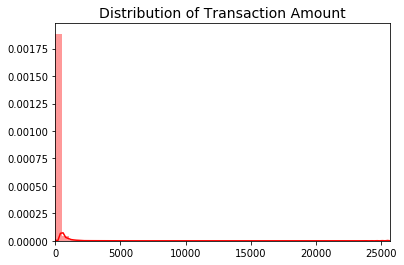

In [6]:
ax = plt.subplots()
ax = sns.distplot(data['Amount'].values, color='r')
ax.set_title('Distribution of Transaction Amount', fontsize=14)
ax.set_xlim([min(data['Amount'].values), max(data['Amount'].values)])

분포가 상당히 오른쪽으로 치우쳐져 있다. 이상치가 존재한다고 볼수도 있다.

(0.0, 172788.0)

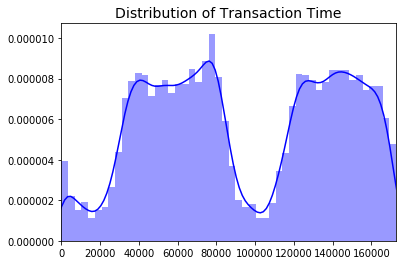

In [7]:
ax = plt.subplots()
ax = sns.distplot(data['Time'].values, color='b')
ax.set_title('Distribution of Transaction Time', fontsize=14)
ax.set_xlim([min(data['Time'].values), max(data['Time'].values)])

In [8]:
data['Class'].value_counts() # imbalanced data임을 알 수 있다.

0    284314
1       492
Name: Class, dtype: int64

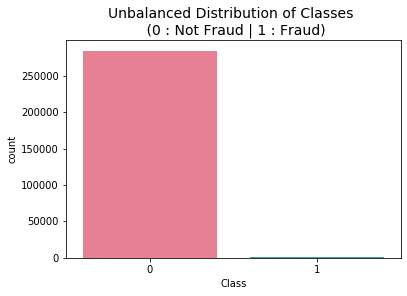

In [9]:
sns.countplot('Class', data=data, palette = 'husl')
plt.title('Unbalanced Distribution of Classes \n (0 : Not Fraud | 1 : Fraud)', fontsize=14)
plt.show()

이 데이터는 매우 imbalanced한 데이터이다. 이럴 때는 minority를 oversampling 하는 방법과 majority를 undersampling 하는 방법이 있는데,  
나는 두번째 방법을 선택한다. (oversampling은 없는 데이터를 있게 만들어야 하기 때문이다.)

In [11]:
from sklearn.utils import resample,shuffle
data_majority = data[data['Class']==0]
data_minority = data[data['Class']==1]
data_majority_downsampled = resample(data_majority,replace=False,n_samples=492,random_state = 123) 
#492 = 기존 데이터셋의 minority 개수
dat = pd.concat([data_minority,data_majority_downsampled])
dat = shuffle(dat)
dat.Class.value_counts() ## balanced 한 dataset = dat

1    492
0    492
Name: Class, dtype: int64

In [12]:
print(dat.shape)

(984, 31)


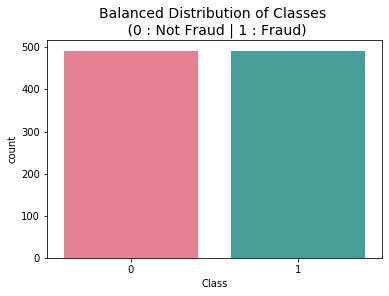

In [13]:
sns.countplot('Class', data=dat, palette='husl')
plt.title('Balanced Distribution of Classes \n (0 : Not Fraud | 1 : Fraud)', fontsize=14)
plt.show()

balance한 dataset `dat`를 생성했다.

(0.0, 2125.87)

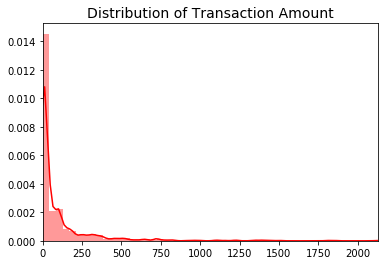

In [14]:
ax = plt.subplots()
ax = sns.distplot(dat['Amount'].values, color='r')
ax.set_title('Distribution of Transaction Amount', fontsize=14)
ax.set_xlim([min(dat['Amount'].values), max(dat['Amount'].values)])

Unbalanced Data에서는 max가 거의 25000이었던 반면에, 지금은 2000정도이며 덕분에 왼쪽으로 많이 분포가 치우쳤던 것이 완화되었다.

(406.0, 172648.0)

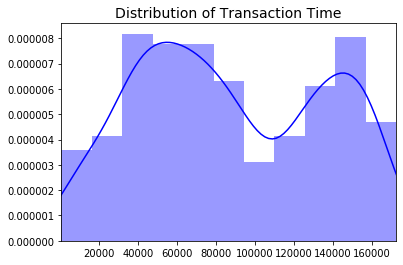

In [15]:
ax = plt.subplots()
ax = sns.distplot(dat['Time'].values, color='b')
ax.set_title('Distribution of Transaction Time', fontsize=14)
ax.set_xlim([min(dat['Time'].values), max(dat['Time'].values)])

#### 상관관계 분석

Text(0.5, 1, 'Heatmap of Unbalanced Data')

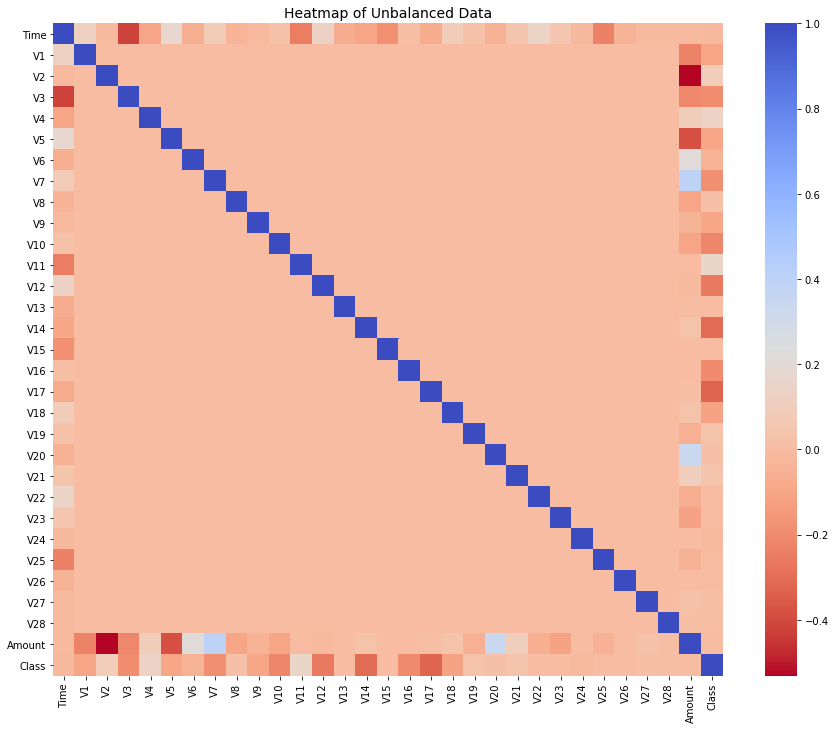

In [30]:
ax = plt.subplots(figsize=(15,12))
ax = sns.heatmap(data.corr(), cmap='coolwarm_r')
ax.set_title('Heatmap of Unbalanced Data', fontsize=14)

Text(0.5, 1, 'Heatmap of Balanced Data(Sub_Sample)')

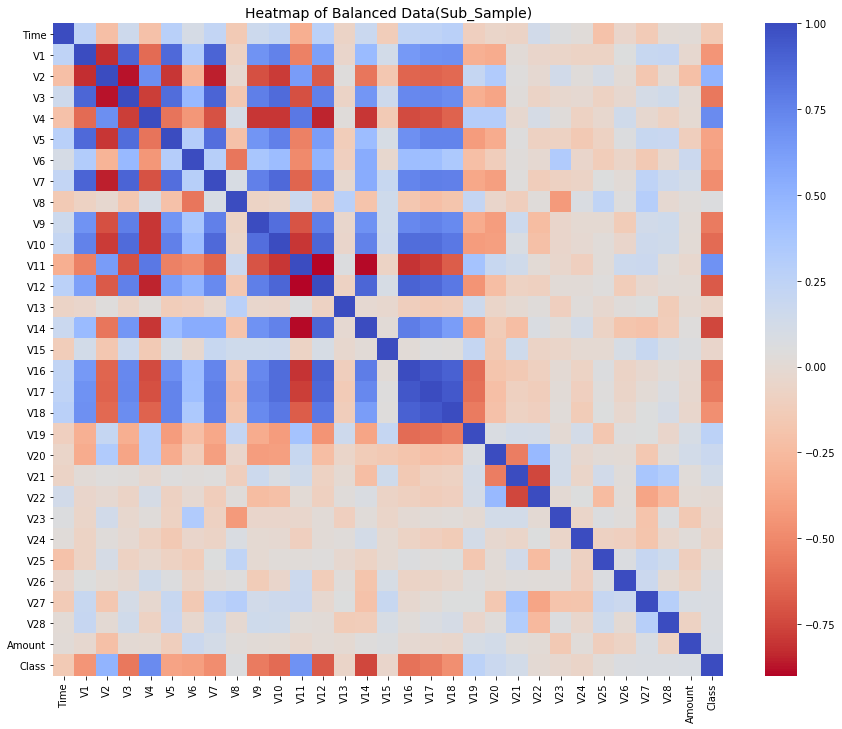

In [31]:
ax = plt.subplots(figsize=(15,12))
ax = sns.heatmap(dat.corr(), cmap='coolwarm_r')
ax.set_title('Heatmap of Balanced Data(Sub_Sample)', fontsize=14)

기존 데이터셋이 284806개의 obs를 가졌던 반면, under sampling한 데이터셋은 984개의 obs를 가진다.  
이는 많은 양의 정보가 손실된다는 단점이 있다.  
그러나 확실히 Balanced data가 분석하기에 더 적합한 것은 틀림없다.  
target variable인 `Class`와 두드러지게 상관관계가 큰 독립변수들이 생겨나기 때문이다. (의미를 더 확실히 해석할 수 있다.)

#### 이상치 처리  
  
변수의 개수가 굉장히 많으므로 target variable `Class`와 상관관계가 높은 `V2`, `V4`, `V11` 의 분포를 우선적으로 확인한다.

Text(0.5, 1.0, 'Distribution of V11')

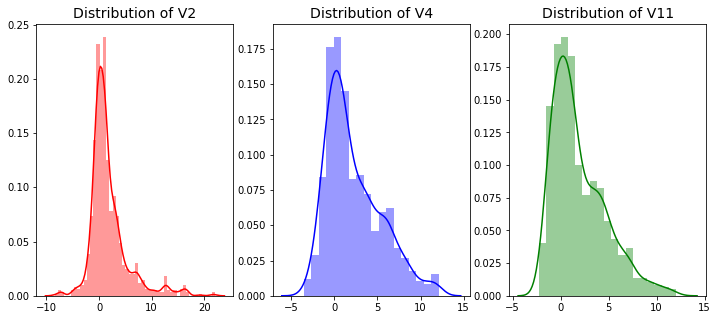

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,5))
sns.distplot(dat['V2'].values, color='r', ax=ax1)
ax1.set_title('Distribution of V2', fontsize=14)

sns.distplot(dat['V4'].values, color='b', ax=ax2)
ax2.set_title('Distribution of V4', fontsize=14)

sns.distplot(dat['V11'].values, color='g', ax=ax3)
ax3.set_title('Distribution of V11', fontsize=14)

그닥 이상치는 없어보인다.

#### Data Split

In [19]:
X = dat.drop(['Class'], axis=1)
y = dat['Class']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 156)

scaling하기 전에 미리 train data와 test data를 구분해준다.

### Data Modeling

거리를 이용하는 모델은 데이터를 scaling 해주는 것이 좋다. 앞에서 볼 수 있듯이, 큰 이상치는 없었으나 혹시 모를 상황을 대비해 이상치의 영향을 최소화 해주는 Robust Scaling을 사용한다.

In [21]:
scaler1 = RobustScaler()
X_train_s = scaler1.fit_transform(X_train) # train data로 훈련, transform
X_test_s = scaler1.transform(X_test) # train data로 훈련된 scaler에 그대로 transform

In [22]:
param_grid = [
    {
        'C' : range(1, 21), # 1부터 20까지의 자연수
        'kernel' : ['sigmoid', 'rbf'],
        'gamma' : ['scale', 'auto'], # gamma = 'scale' 이면, gamma = 1 / (n_features * X.var()) 
                                     # gamma = 'auto' 이면, gamma = 1 / n_features
    },
    {
       'C' : range(1, 21), # 1부터 20까지의 자연수
        'kernel' : ['linear'], #linear SVM에서는 gamma 옵션을 부여하지 않기 때문에 생략
    }
]

grid = GridSearchCV(SVC(), cv=3, param_grid = param_grid, scoring='recall', verbose=3) # recall 재현율 사용
grid.fit(X_train_s, y_train)

#verbose가 클수록 진행상황을 많이 알려줌. default로 두면 dataset이 커졌을 때 내컴퓨터/파이썬/코드 중에서 어디가 문제인지 모른다.

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] C=1, gamma=scale, kernel=sigmoid ................................
[CV] .... C=1, gamma=scale, kernel=sigmoid, score=0.820, total=   0.1s
[CV] C=1, gamma=scale, kernel=sigmoid ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .... C=1, gamma=scale, kernel=sigmoid, score=0.842, total=   0.1s
[CV] C=1, gamma=scale, kernel=sigmoid ................................
[CV] .... C=1, gamma=scale, kernel=sigmoid, score=0.833, total=   0.1s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.887, total=   0.1s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.880, total=   0.1s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.833, total=   0.1s
[CV] C=1, gamma=auto, kernel=sigmoid .................................
[CV] ..... C=1, gamma=auto, kernel=sigmoid, score=0.782, total=   0.0s
[CV] C=1, gamma=auto, kernel=sigmoid .................................
[CV] ..... C=1, gamma=auto, kernel=sigmoid, score=0.865, total=   0.0s
[CV] C=1, gamma=auto, kernel=sigmoid .................................
[CV] .

[CV] ......... C=5, gamma=auto, kernel=rbf, score=0.932, total=   0.0s
[CV] C=6, gamma=scale, kernel=sigmoid ................................
[CV] .... C=6, gamma=scale, kernel=sigmoid, score=0.805, total=   0.0s
[CV] C=6, gamma=scale, kernel=sigmoid ................................
[CV] .... C=6, gamma=scale, kernel=sigmoid, score=0.865, total=   0.0s
[CV] C=6, gamma=scale, kernel=sigmoid ................................
[CV] .... C=6, gamma=scale, kernel=sigmoid, score=0.879, total=   0.0s
[CV] C=6, gamma=scale, kernel=rbf ....................................
[CV] ........ C=6, gamma=scale, kernel=rbf, score=0.887, total=   0.0s
[CV] C=6, gamma=scale, kernel=rbf ....................................
[CV] ........ C=6, gamma=scale, kernel=rbf, score=0.917, total=   0.0s
[CV] C=6, gamma=scale, kernel=rbf ....................................
[CV] ........ C=6, gamma=scale, kernel=rbf, score=0.902, total=   0.0s
[CV] C=6, gamma=auto, kernel=sigmoid .................................
[CV] .

[CV] ........ C=10, gamma=auto, kernel=rbf, score=0.895, total=   0.1s
[CV] C=10, gamma=auto, kernel=rbf ....................................
[CV] ........ C=10, gamma=auto, kernel=rbf, score=0.940, total=   0.1s
[CV] C=10, gamma=auto, kernel=rbf ....................................
[CV] ........ C=10, gamma=auto, kernel=rbf, score=0.932, total=   0.1s
[CV] C=11, gamma=scale, kernel=sigmoid ...............................
[CV] ... C=11, gamma=scale, kernel=sigmoid, score=0.835, total=   0.0s
[CV] C=11, gamma=scale, kernel=sigmoid ...............................
[CV] ... C=11, gamma=scale, kernel=sigmoid, score=0.865, total=   0.1s
[CV] C=11, gamma=scale, kernel=sigmoid ...............................
[CV] ... C=11, gamma=scale, kernel=sigmoid, score=0.826, total=   0.1s
[CV] C=11, gamma=scale, kernel=rbf ...................................
[CV] ....... C=11, gamma=scale, kernel=rbf, score=0.880, total=   0.1s
[CV] C=11, gamma=scale, kernel=rbf ...................................
[CV] .

[CV] .... C=15, gamma=auto, kernel=sigmoid, score=0.865, total=   0.0s
[CV] C=15, gamma=auto, kernel=sigmoid ................................
[CV] .... C=15, gamma=auto, kernel=sigmoid, score=0.795, total=   0.0s
[CV] C=15, gamma=auto, kernel=rbf ....................................
[CV] ........ C=15, gamma=auto, kernel=rbf, score=0.902, total=   0.1s
[CV] C=15, gamma=auto, kernel=rbf ....................................
[CV] ........ C=15, gamma=auto, kernel=rbf, score=0.940, total=   0.1s
[CV] C=15, gamma=auto, kernel=rbf ....................................
[CV] ........ C=15, gamma=auto, kernel=rbf, score=0.924, total=   0.0s
[CV] C=16, gamma=scale, kernel=sigmoid ...............................
[CV] ... C=16, gamma=scale, kernel=sigmoid, score=0.812, total=   0.0s
[CV] C=16, gamma=scale, kernel=sigmoid ...............................
[CV] ... C=16, gamma=scale, kernel=sigmoid, score=0.857, total=   0.0s
[CV] C=16, gamma=scale, kernel=sigmoid ...............................
[CV] .

[CV] ........ C=20, gamma=auto, kernel=rbf, score=0.910, total=   0.0s
[CV] C=20, gamma=auto, kernel=rbf ....................................
[CV] ........ C=20, gamma=auto, kernel=rbf, score=0.932, total=   0.0s
[CV] C=20, gamma=auto, kernel=rbf ....................................
[CV] ........ C=20, gamma=auto, kernel=rbf, score=0.924, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.895, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.910, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.917, total=   0.1s
[CV] C=2, kernel=linear ..............................................
[CV] .................. C=2, kernel=linear, score=0.895, total=   0.0s
[CV] C=2, kernel=linear ..............................................
[CV] .

[CV] ................. C=19, kernel=linear, score=0.917, total=   0.1s
[CV] C=19, kernel=linear .............................................
[CV] ................. C=19, kernel=linear, score=0.917, total=   0.1s
[CV] C=20, kernel=linear .............................................
[CV] ................. C=20, kernel=linear, score=0.902, total=   0.1s
[CV] C=20, kernel=linear .............................................
[CV] ................. C=20, kernel=linear, score=0.917, total=   0.2s
[CV] C=20, kernel=linear .............................................
[CV] ................. C=20, kernel=linear, score=0.917, total=   0.1s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   16.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': range(1, 21), 'gamma': ['scale', 'auto'],
                          'kernel': ['sigmoid', 'rbf']},
                         {'C': range(1, 21), 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=3)

In [23]:
grid.cv_results_

{'mean_fit_time': array([0.04533799, 0.03599954, 0.01999728, 0.0373311 , 0.03599795,
        0.08266656, 0.0439984 , 0.04666448, 0.04133431, 0.05333249,
        0.03066317, 0.03599819, 0.02533515, 0.03066365, 0.01466497,
        0.0359993 , 0.02266828, 0.02800067, 0.01866666, 0.02933343,
        0.01199857, 0.01734598, 0.01334739, 0.01866349, 0.01066502,
        0.02000451, 0.01199873, 0.02133393, 0.01200096, 0.01600051,
        0.01466672, 0.02534691, 0.01333348, 0.01999966, 0.01066756,
        0.02266725, 0.01200151, 0.02666775, 0.01867739, 0.06666501,
        0.03600764, 0.04266516, 0.02533213, 0.06533384, 0.03200833,
        0.04399967, 0.02266796, 0.05733514, 0.02666664, 0.05733418,
        0.02000133, 0.04533315, 0.01999847, 0.02933137, 0.01866579,
        0.03866736, 0.01865983, 0.03200213, 0.018665  , 0.03733444,
        0.02133115, 0.03066619, 0.01600003, 0.04000123, 0.02133115,
        0.02666632, 0.01199873, 0.03199959, 0.01466576, 0.02266431,
        0.01466854, 0.03466757,

In [24]:
print(grid.best_params_)
print(grid.best_score_) # best parameter로 얻은 best Recall (재현율) 값

{'C': 7, 'gamma': 'auto', 'kernel': 'rbf'}
0.9246411483253588


* Linear SVM과 Non-linear SVM 중 sigmoid kernel, 그리고 gaussian kernel을 사용한 SVM.  
총 3가지의 SVM Model들을 사용했고, 재현율(Recall)을 기준으로 가장 좋은 모델은 Gaussian SVM 이었다.

* scoring 기준은 데이터 특성 상 recall(진짜 양성 중 예측 양성)을 선택하였다.  
사기인지(=True인지) 사기가 아닌지(=False인지)를 구별해내야 하는 경우 accuracy가 낮더라도  
실제 사기인 것 중에서 예측한 사기의 비율이 높으면 (높은 확률로 사기임을 예측해내면) 좋은 모델이기 때문이다.

In [25]:
model1 = SVC(C=9, gamma = 'auto', kernel='rbf') # Non-linear SVM & Gaussian kernel 사용
model1.fit(X_train_s, y_train)
model1_pred = model1.predict(X_train_s)
confusion_matrix(y_train, model1_pred) # X_train을 가지고 예측한 값과 y_train의 confusion matrix

array([[385,   4],
       [ 17, 381]], dtype=int64)

True와 False 모두가 대체로 올바르게 분류되고 있다.

In [26]:
model1.n_support_ # 각 클래스당 서포트의 개수

array([106, 133])

### Data Scores

Test data를 가지고 모델을 평가한 결과는 다음과 같다.

In [27]:
print('accuracy : ', model1.score(X_test_s, y_test)) # Accuracy (정확한 예측 비율)
print('precision : ', precision_score(y_test, model1.predict(X_test_s))) # Precision (예측 사기 중 진짜 사기)
print('recall : ', recall_score(y_test, model1.predict(X_test_s))) # Recall (진짜 사기 중 예측 사기)
print('f1_score : ', f1_score(y_test, model1.predict(X_test_s))) # Precision과 Recall의 조화 평균

accuracy :  0.9238578680203046
precision :  0.9247311827956989
recall :  0.9148936170212766
f1_score :  0.9197860962566845


모든 score가 대체로 적당히 높다. Balanced Dataset에서 이정도의 모델 평가 지표를 갖는 다는 것은 위 모델이 아주 적합한 모델이라고 말할 수 있다.

### Conclusion 
  
  
  
1. Imbalanced한 데이터를 다루는 데에는 minority의 sample을 더 만들어내는 oversampling과, majority의 sample을 랜덤하게 제거하는 undersampling이 있다. 위 과제에서는 후자를 선택하여 진행하였고, 그 결과 변수 간 상관관계를 증가시킨 data를 분석에 사용할 수 있었다.  
  
  
2. GridSearch 에서 test한 svm은 Linear SVM, sigmoid kernel을 사용한 Nonlinear SVM, gaussian kernel을 사용한 Nonlinear SVM 총 세가지이다.
  이 중 optimal model로 선택된 것은 gaussian kernel을 사용한 Nonlinear SVM이다. (거의 대부분 그렇다고 한다.)  
  
  
3. 사실 Gaussian kernel의 단점은 데이터가 크면 시간이 많이 걸린다는 것인데, 위 분석에서는 big data를 undersampling 하였기 때문에 불편함을 느끼진 않았다.  
  
  
4. 또한 사기 데이터 특성 상, 실제 사기 케이스를 얼마나 올바르게 예측해내냐가 중요하기 때문에 Grid Search 에서 scoring 옵션을 재현율(recall)로 설정하였다. 물론 다른 accuracy, precision, f1_score 등도 적당히 높은 값을 보인다.